Test environment config.

In [1]:
import sys
print(sys.executable)
import torch
print(torch.__file__) 
print(torch.cuda.is_available())
from torch.utils import collect_env
print(collect_env.main())


/scratch/users/k20014224/bvenv/bin/python
/scratch/users/k20014224/bvenv/lib/python3.8/site-packages/torch/__init__.py
True
PyTorch version: 2.0.0+cu117
Is debug build: False
CUDA used to build PyTorch: 11.7
ROCM used to build PyTorch: N/A

OS: Ubuntu 20.04.6 LTS (x86_64)
GCC version: (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Clang version: Could not collect
CMake version: version 3.26.1
Libc version: glibc-2.31

Python version: 3.8.10 (default, Mar 13 2023, 10:26:41)  [GCC 9.4.0] (64-bit runtime)
Python platform: Linux-5.15.0-69-generic-x86_64-with-glibc2.29
Is CUDA available: True
CUDA runtime version: 10.1.243
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA A100-SXM4-40GB
Nvidia driver version: 510.108.03
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Add

Check if the environment has access to the NVIDIA A100 GPU.

In [2]:
!nvidia-smi 

Thu Apr  6 00:25:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:CA:00.0 Off |                    0 |
| N/A   48C    P0    62W / 400W |   7840MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Diffusion Model - Tests for the UNet model

A simple implementation of the diffusion model in PyTorch without text decoder and encoder for a full text-to-image generation pipeline.

In [3]:
import torch
import torchvision 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms 
# from torchvision.transforms import Compose, ToTensor, Lambda, Resize, CenterCrop, RandomHorizontalFlip, ToPILImage
from torch.utils.data import DataLoader
import numpy as np
from torch import nn
import math

## Step 1 - Forward Diffusion Process

### Step 1.1 - The linear schedule used in the forward diffusion process to calculate the alphas, betas, diffusion and posterior.

In [4]:
# A linear schedule as proposed in https://arxiv.org/pdf/2102.09672.pdf
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02

    return torch.linspace(beta_start, beta_end, timesteps)

# A cosine schedule as proposed in https://arxiv.org/abs/2102.09672.pdf
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    return torch.clip(betas, 0.0001, 0.9999)

# A quadratic schedule
def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02

    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

# A sigmoid schedule
def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)

    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

# Returns a specific index t of a passed list of values vals while considering the batch dimension.
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())

    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Returns the diffusion model's forward diffusion sample, taking an image x_0 and a timestep t as input and returning the noisy version.
def forward_diffusion_sample(x_0, t, device="cpu"):

    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculate for diffusion q(x_t | x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Calculate for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### Image Preprocessing Helper Functions

In [5]:
# Parameters for the dataset with image size of 64x64, 128x128, 256x256 
# These will be used to resize the images and test the models on different image sizes
IMG_SIZE = 64
IMG_SIZE_128 = 128
IMG_SIZE_256 = 256

# Batch size for training and testing with 128 images per batch and 256 images per batch.
BATCH_SIZE = 128
BATCH_SIZE_256 = 256

# The tensor transformer for the dataset
def load_transformed_dataset():
    transform = transforms.Compose([ 
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t * 2 - 1)
    ])

    data_transform = transform

    train = datasets.CelebA(root='', split="train", download=True, transform=data_transform)

    test = datasets.CelebA(root='', split="test", download=True, transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])


# Load the transformer dataset
data = load_transformed_dataset()

# Appends the data into a dataloader with a batch size of 128 or 256 depending on investigation
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# The reverse transformer for the dataset to show the images back to their original form
def reverse_tensor_img(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t*255),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    plt.imshow(reverse_transform(image))

Files already downloaded and verified
Files already downloaded and verified


Testing if the forward diffusion process is working correctly.

## Step 2 - Backward Diffusion Process (U-Net)

In [6]:
# The convolutional block for the model
# The block consists of two convolutional layers with each one having its own batch normalization and a relu activation function
# The block also has a time embedding layer that is used to add the time embedding to the convolutional layers
# The block also has skip connections using the time embedding layer and the convolutional layers to add the time embedding to the skip connections
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, time_emb_dim, up=False):
        super().__init__()
        # Time embedding layer
        self.time_mlp =  nn.Linear(time_emb_dim, out_channel)

        # First convolutional layers
        # If up is true then add a convolutional transpose layer to upsample the channels
        if up:
            self.conv1 = nn.Conv2d(2*in_channel, out_channel, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channel, out_channel, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
            self.transform = nn.Conv2d(out_channel, out_channel, 4, 2, 1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)

        # Batch normalization layers for both convolutional layers
        self.bnorm1 = nn.BatchNorm2d(out_channel)
        self.bnorm2 = nn.BatchNorm2d(out_channel)

        # Relu activation function
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

# A sinusoidal time embedding layer as described in the paper https://arxiv.org/pdf/1706.03762.pdf
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# A UNet architecture for the image denoising task with time embedding in each layer
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3 # RGB: 3 channels for RED, GREEN, BLUE
        down_channels = (64, 128, 256, 512, 1024) # Number of channels in each downsample layer
        up_channels = (1024, 512, 256, 128, 64) # Number of channels in each upsample layer
        out_dim = 1 # 1x1 final of output channels
        time_emb_dim = 32 # Dimension of time embedding

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Final output 1x1 conv
        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

# Test unit suite

Image testing.

Files already downloaded and verified


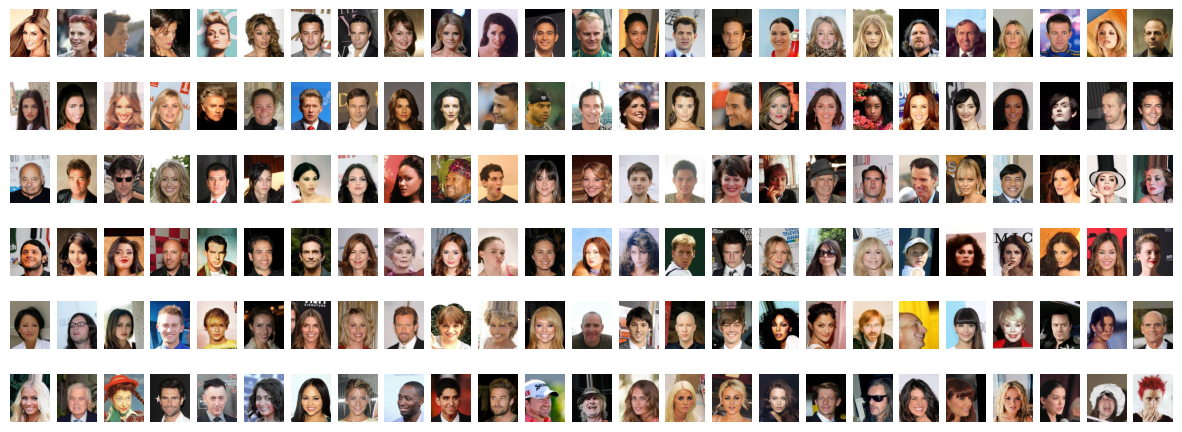

In [7]:
# Generates 150 samples of 25 columns x 10 rows of images
def show(dataset, num_sample=150, cols=25, rows=10):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):
        if i == num_sample:
            break
        plt.subplot(num_sample // rows + 1, cols, i + 1)
        plt.axis('off')
        plt.imshow(img[0])

# Download the dataset 
# *WARNING:* This will take a while to download (depending on connection speed) on the first ever run of this notebook
data = torchvision.datasets.CelebA(root='', split="train", download=True)

# Show the first 150 samples
show(data)

/tmp/slurm-tmp.2054440/ipykernel_193447/1265622936.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx//stepsize) + 1)


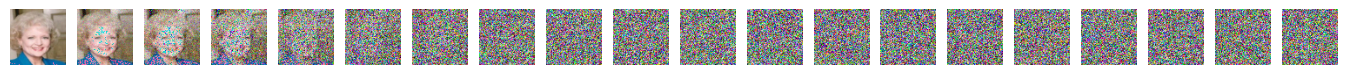

In [8]:
# Convert reverse_tensor_img to a cuda tensor function
# reverse_tensor_img = torch.jit.script(reverse_tensor_img)

# Load a single image from the dataloader
image = next(iter(dataloader))[0]

# Add image dimensions for the graph, the amount of image steps and the step sizes
plt.figure(figsize=(18, 18))
plt.axis('off')
num_images = 20
stepsize = int(T/num_images)

# Plot the image with the step size and show the image
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    plt.axis('off')
    reverse_tensor_img(image)

Simple test for the UNet model.

In [9]:
import unittest

class TestImageSizes(unittest.TestCase):

    def test_unet_64(self):
        # Test the unet architecture on 64x64 images
        model = SimpleUnet()
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)  
        y = model(image, t)
        assert y.shape == torch.Size([1, 3, 64, 64])
    
    def test_unet_128(self):
        # Test the unet architecture on 128x128 images
        model = SimpleUnet()
        image = torch.randn(1, 3, IMG_SIZE_128, IMG_SIZE_128)
        t = torch.Tensor([0]).type(torch.int64)  
        y = model(image, t)
        assert y.shape == torch.Size([1, 3, 128, 128])

    def test_unet_256(self):
        # Test the unet architecture on 256x256 images
        model = SimpleUnet()
        image = torch.randn(1, 3, IMG_SIZE_256, IMG_SIZE_256)
        t = torch.Tensor([0]).type(torch.int64)  
        y = model(image, t)
        assert y.shape == torch.Size([1, 3, 256, 256])

class TestConvolutions(unittest.TestCase):

    def test_conv2d_64(self):
        # Test the conv2d layer on 64x64 images
        model = SimpleUnet()
        model_conv2d = model.conv0
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)  
        model_conv2d = model(image, t)
        assert model_conv2d.shape == torch.Size([1, 3, 64, 64])

    def test_output_64(self):
        # Test the output layer on 64x64 images
        model = SimpleUnet()
        model_output = model.output
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)  
        model_output = model(image, t)
        assert model_output.shape == torch.Size([1, 3, 64, 64])
    
    def test_downs_64(self):
        # Test the downsampling layers on 64x64 images
        model = SimpleUnet()
        model_downs = model.downs
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)  
        model_downs = model(image, t)
        assert model_downs.shape == torch.Size([1, 3, 64, 64])

    def test_ups_64(self):
        # Test the upsampling layers on 64x64 images
        model = SimpleUnet()
        model_ups = model.ups
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)  
        model_downs = model(image, t)
        assert model_downs.shape == torch.Size([1, 3, 64, 64])

class TestUNetArc(unittest.TestCase):

    def test_architecture_time_emb(self):
        # Test the UNet architecture is correctly set up
        model = SimpleUnet()
        image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
        t = torch.Tensor([0]).type(torch.int64)
        y = model(image, t)
        
        # Test time embedding
        assert model.time_mlp(t).shape == torch.Size([1, 32])

# Test suit to allow to run all tests at once, remove specific tests if needed too.
def suit():
    suite = unittest.TestSuite()
    suite.addTest(TestImageSizes('test_unet_64'))
    suite.addTest(TestImageSizes('test_unet_128'))
    suite.addTest(TestImageSizes('test_unet_256'))
    suite.addTest(TestConvolutions('test_conv2d_64'))
    suite.addTest(TestConvolutions('test_output_64'))
    suite.addTest(TestConvolutions('test_downs_64'))
    suite.addTest(TestConvolutions('test_ups_64'))
    suite.addTest(TestUNetArc('test_architecture_time_emb'))
    return suite

if __name__ == '__main__':
    runner = unittest.TextTestRunner()
    runner.run(suit())

# unittest.main(argv=['-t'], verbosity=2, exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 5.827s

OK
